# Imports

In [2]:
from datetime import datetime, timedelta
import random
import json
import statistics
import re
from typing import Dict
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import surprise
import implicit
import nltk
from nltk.corpus import stopwords
import scipy.sparse as sparse
from scipy.sparse.linalg import spsolve
from sklearn.linear_model import SGDRegressor
from sklearn.metrics.pairwise import linear_kernel, cosine_similarity
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import LatentDirichletAllocation
from tqdm.notebook import tqdm_notebook

# Reading the data

In [3]:
user_df = pd.read_csv("./columns_removed/users.csv", index_col="Unnamed: 0")

service_subscripted_df = pd.read_csv(
    "./columns_removed/service_subscripted.csv", index_col="Unnamed: 0"
)

service_df = pd.read_csv("./columns_removed/services.csv", index_col="Unnamed: 0")

# Preprocessing the data

In [4]:
def getObjectIds(strings):
    strings = json.loads(strings.replace("'", '"')) if type(strings) == str else None
    return [string["objectId"] for string in strings] if not strings is None else None

def getObjectId(string):
    return (
        json.loads(string.replace("'", '"'))["objectId"]
        if type(string) == str
        else None
    )

In [5]:
print("Extracting IDs in service_subscripted_df")
service_subscripted_df["user"] = service_subscripted_df["user"].apply(
    getObjectId
)
service_subscripted_df["service"] = service_subscripted_df["service"].apply(
    getObjectId
)
service_subscripted_df["servicePrice"] = service_subscripted_df[
    "servicePrice"
].apply(getObjectId)
service_subscripted_df["serviceSubscriptedStatus"] = service_subscripted_df[
    "serviceSubscriptedStatus"
].apply(getObjectId)

service_df["servicePrices"] = service_df["servicePrices"].apply(getObjectIds)
service_df["serviceCategories"] = service_df["serviceCategories"].apply(
    getObjectIds
)

Extracting IDs in service_subscripted_df


In [6]:
service_subscripted_df["createdAt"] = pd.to_datetime(
    service_subscripted_df["createdAt"]
)
service_subscripted_df = service_subscripted_df.sort_values(by="createdAt")

In [7]:
train_set = service_subscripted_df.copy()
train_subscribe_count = train_set.groupby(["user", "service"], as_index=False).size()
train_data = train_subscribe_count[["user", "service", "size"]].join(
    service_df[
        [
            "objectId",
            "serviceCategories",
            "servicePrices",
            "name",
            "task_name",
            "keywordServiceCategories",
            "description",
            "haveAndroidApp",
            "haveIOSApp",
        ]
    ].set_index("objectId"),
    on="service",
    how="left",
)

In [8]:
train_data['size'].describe()

count    406.000000
mean       5.783251
std       18.685501
min        1.000000
25%        1.000000
50%        2.000000
75%        4.000000
max      311.000000
Name: size, dtype: float64

In [9]:
service_count = train_data[['user', 'service', 'size']].groupby('service', as_index=False).sum()
# display(service_count.head(10))
service_count['size'].describe()

count     65.000000
mean      36.123077
std       88.431560
min        1.000000
25%        6.000000
50%       16.000000
75%       31.000000
max      654.000000
Name: size, dtype: float64

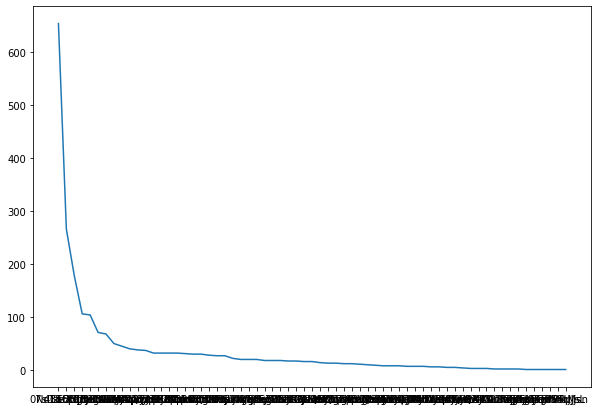

In [10]:
service_count.sort_values(by='size', ascending=False, inplace=True)
plt.figure(figsize=(10,7))
plt.plot(service_count["service"].values, service_count["size"].values)

In [11]:
user_count = train_data[['user', 'service', 'size']].groupby('user', as_index=False).sum()
# display(user_count.head(10))
user_count['size'].describe()

count     58.000000
mean      40.482759
std      122.281275
min        1.000000
25%        2.000000
50%        6.000000
75%       19.000000
max      710.000000
Name: size, dtype: float64

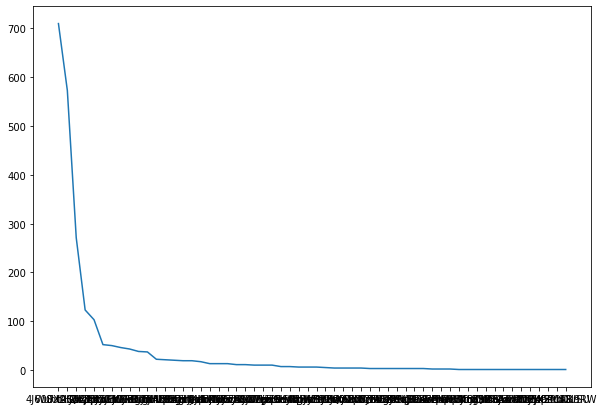

In [12]:
user_count.sort_values(by='size', ascending=False, inplace=True)
plt.figure(figsize=(10,7))
plt.plot(user_count["user"].values, user_count["size"].values)

In [13]:
matrix_size = (
    len(train_data['user'].unique()) * len(train_data['service'].unique())
)  # Number of possible interactions in the matrix
num_interactions = train_data.count()['size']  # Number of items interacted with
sparsity = 100 * (1 - (num_interactions / matrix_size))
sparsity

89.23076923076923

In [14]:
user_count

,user,size
7,4J60SXAGWB,710
34,Wuht2SEQKc,573
0,0ULHUAAtf3,271
52,t9IQcZ3cdL,123
21,JVEJq4hHlI,103
35,ZxcHkwHGRL,52
14,C3X1fCjFik,50
48,pJyGMKcKXX,46
3,1jCnE220nA,43
41,jzl9egzBnk,38
